In [1]:
# Imports 

from sklearn.preprocessing import LabelBinarizer 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 

In [2]:
data = pd.read_csv('../data/data_preprocessed.csv')

### Frequency Distributions

#### `Country` and `Cat_sex`:

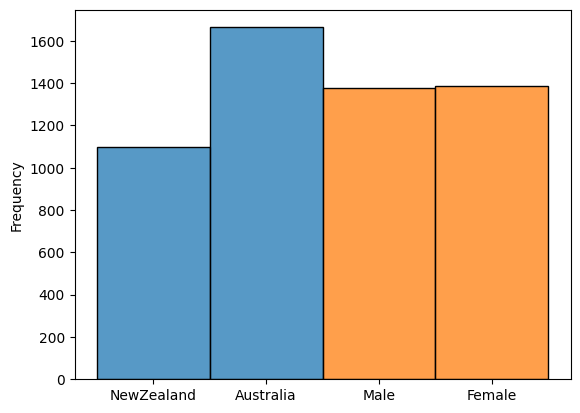

In [3]:
sns.histplot(data['Country'])
sns.histplot(data['Cat_sex'])
plt.xlabel('')
plt.ylabel('Frequency')

%matplotlib inline

#### Personality Traits:

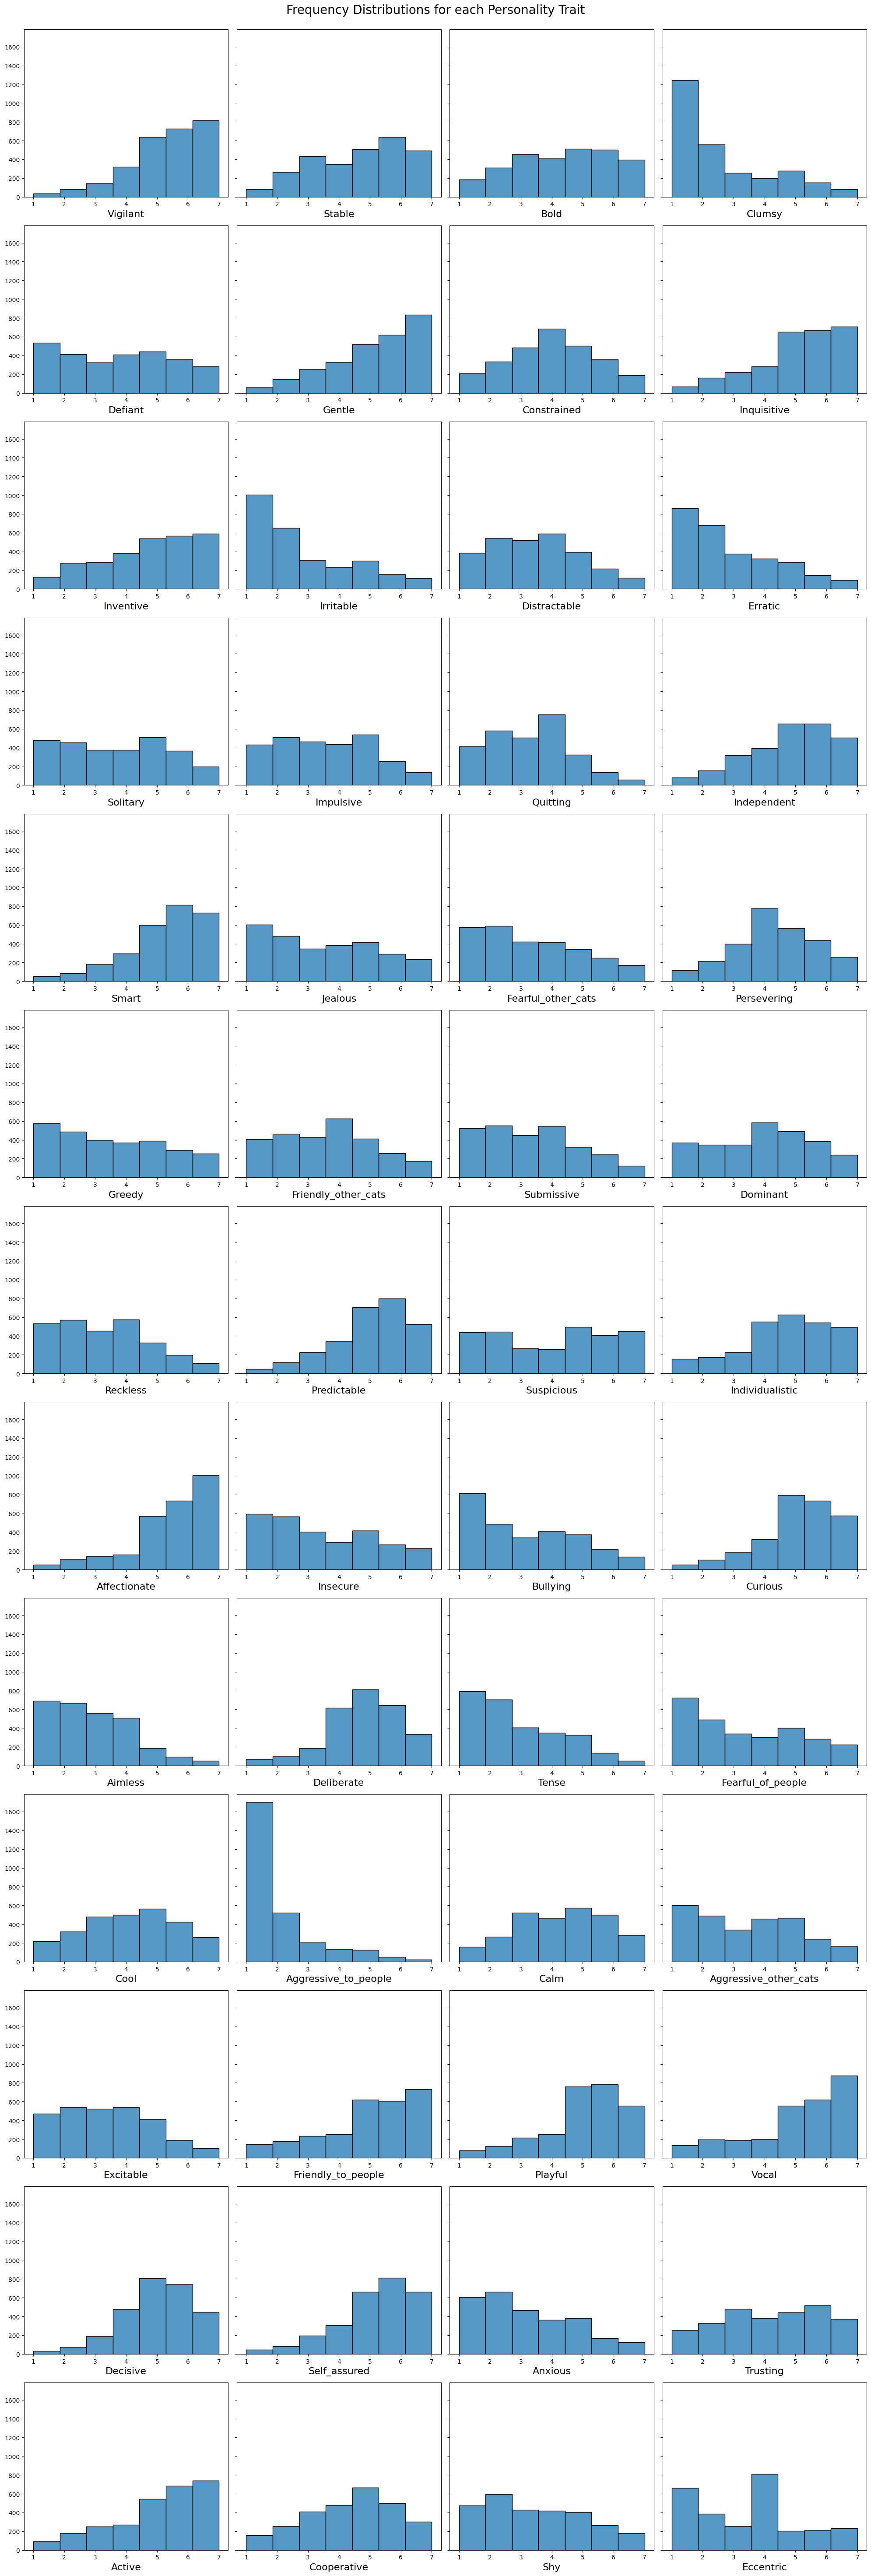

In [4]:
traits = data.select_dtypes(include='int64')

fig, axes = plt.subplots(13, 4, figsize=(20, 60), sharey=True)
axes = axes.flatten()


for i, column in enumerate(traits.columns):
    sns.histplot(data[column], ax=axes[i], bins=7)
    # axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column, fontsize=16)
    axes[i].set_ylabel("")
    

plt.suptitle('Frequency Distributions for each Personality Trait', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

%matplotlib inline

### Notes: 

There are some traits that have a very visible skew, and a few traits appear to be normally distributed.  

##### Left skew:  
- Vigilant, Gentle, Inventive, Independent, Smart, Predictable, Individualistic, Affectionate, Curious, Friendly_to_people, Playful, Vocal, Decisive, Self_assured, Active

##### Right skew: 
- Clumsy, Irritable, Erratic, Bullying, Aimless, Tense, Aggressive_to_people, Anxious

##### Normal Distribution:
- Constrianed, Perserving, Friendly_other_cats, Cool, Calm, Cooperative

The distribution of the `Eccentric` trait stands out as having a high frequency for 1 and 4 while having less variance in the other ratings. This suggests that most cats are either not eccentric or average. However, since the data is based on the cat owners' subjective self reports, it is also possible that a large number of owners are selecting the lowest or most central rating as a default rating for that trait. If the trait does not have notable correlations with other traits I will consider removing it. 

### Pairwise comparison 

In [5]:
# Encoding `Country` and `Cat_sex` columns 

lb = LabelBinarizer()
lb.fit(data['Country'])
country_values = lb.transform(data['Country'])
data['Country'] = country_values

lb.fit(data['Cat_sex'])
catsex_values = lb.transform(data['Cat_sex'])
data['Cat_sex'] = catsex_values

In [6]:
correlation_matrix = data.corr()

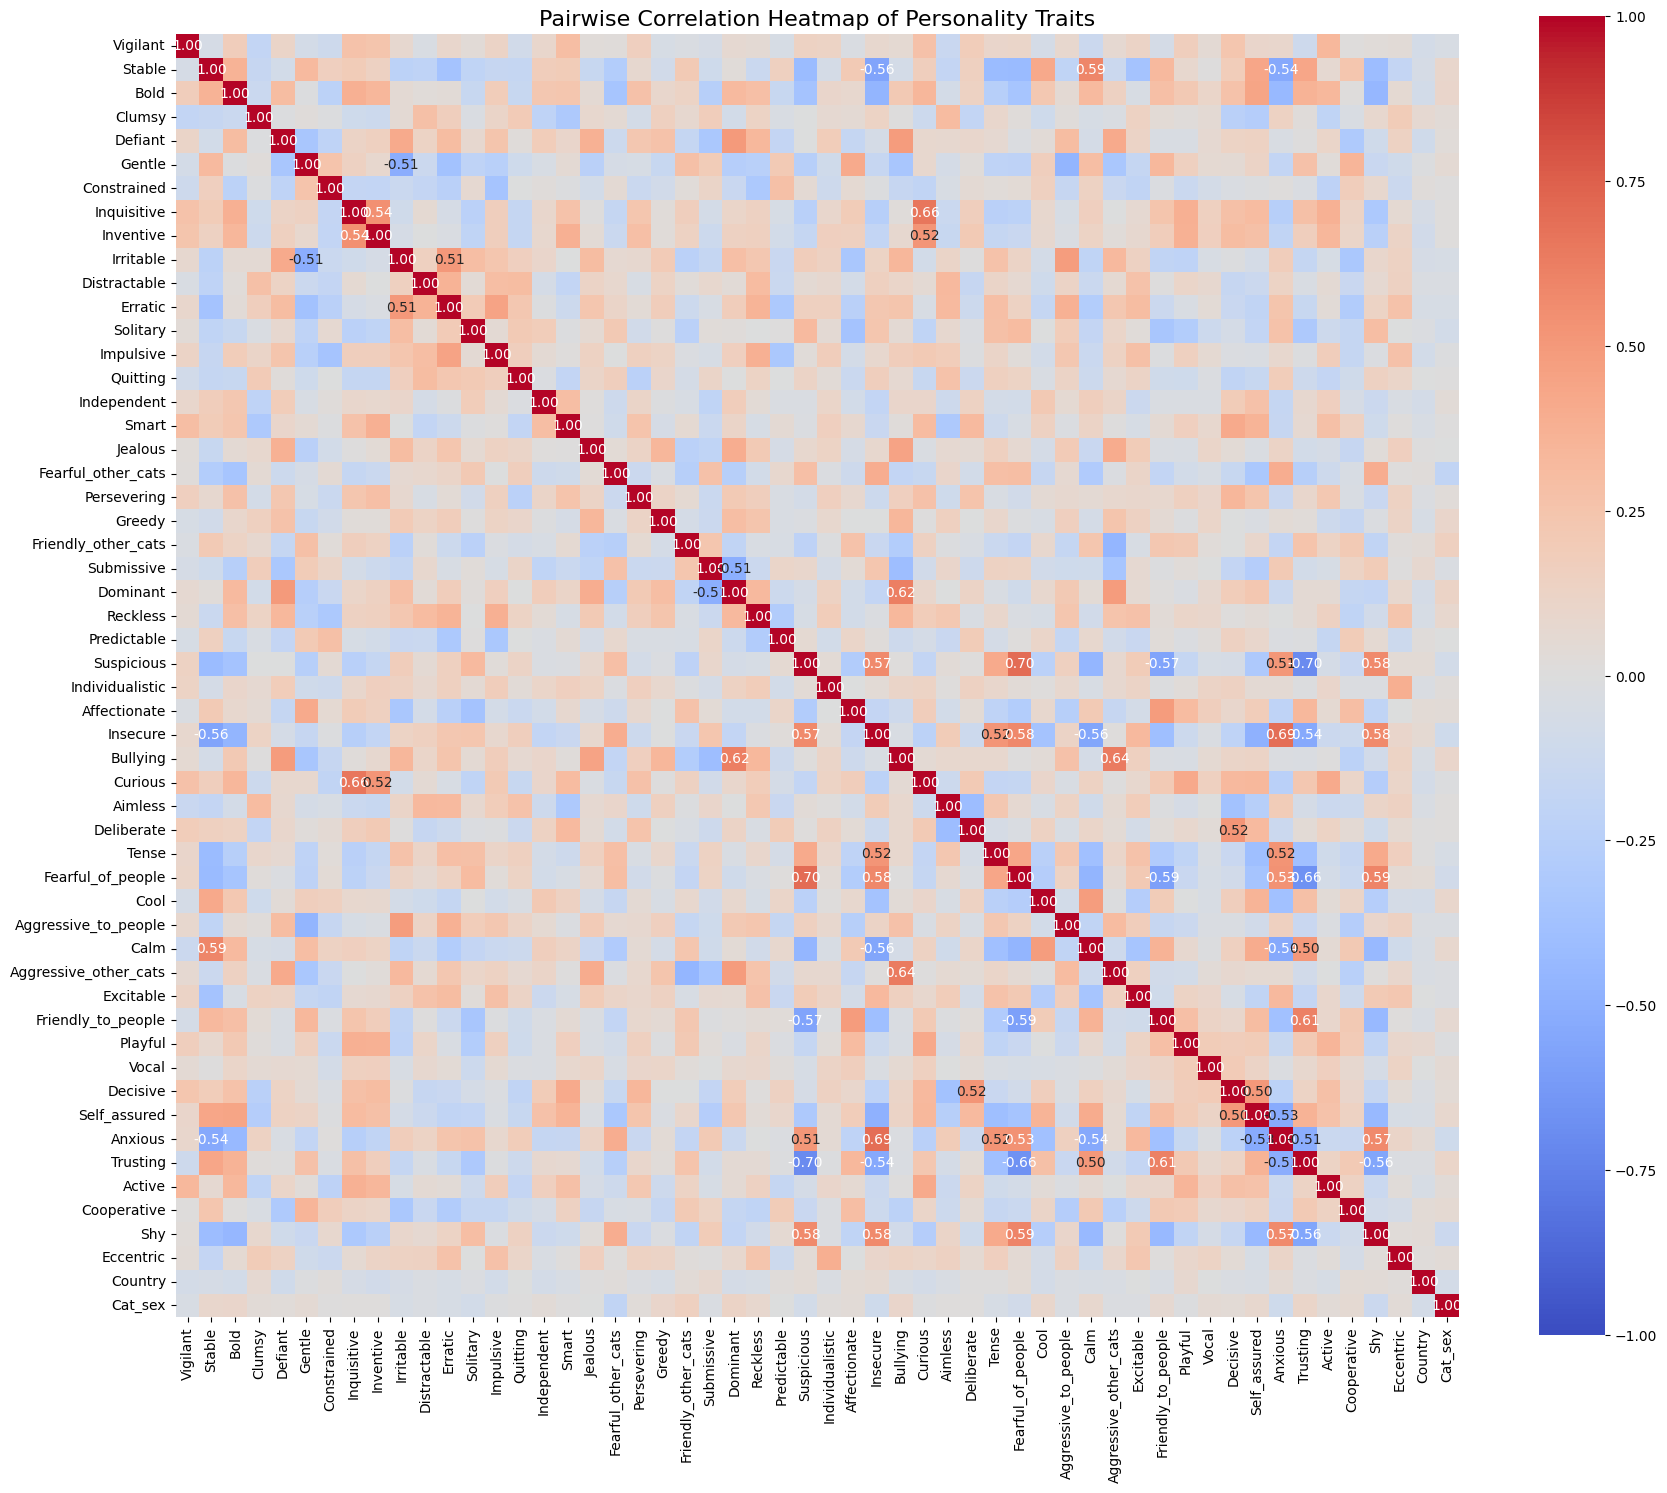

In [7]:
plt.figure(figsize=(18, 15))

# Only annotating pairs where the correlation is > 0.5
threshold = 0.5
annot = correlation_matrix.map(lambda v: f"{v:.2f}" if abs(v) >= threshold else "")

sns.heatmap(
    correlation_matrix,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=annot, 
    fmt='',
    square=True,
    xticklabels=True,
    yticklabels=True
)
plt.title('Pairwise Correlation Heatmap of Personality Traits', fontsize=16)
plt.tight_layout()
plt.show()

As expected, the `Eccentric` trait does not seem to correlate much with the other traits so I will be removing it going forward. There is also no visible correlation between either `Country` and `Cat_sex` and all traits. As such, I can reasonable conclude that both factors do not affect any traits, and I will be removing the `Country` column as well. The `Cat_sex` column is kept to allow users of the recommender to filter if they want cats that are only males, only females, or both in their recommendations. 

In [8]:
data = data.drop(columns=['Eccentric', 'Country'])

### Inspecting correlated pairs (> 0.5)

In [9]:
correlation_matrix.replace(to_replace=1, value=np.nan, inplace=True)
pairs = correlation_matrix.unstack().dropna()
pairs = pairs[pairs.abs() > 0.5]
pairs = pairs[pairs.index.map(lambda x: x[0] < x[1])]
pairs = pairs.reindex(pairs.abs().sort_values(ascending=False).index)
pairs

Fearful_of_people      Suspicious            0.702191
Suspicious             Trusting             -0.700766
Anxious                Insecure              0.694389
Fearful_of_people      Trusting             -0.664570
Curious                Inquisitive           0.662097
Aggressive_other_cats  Bullying              0.639967
Bullying               Dominant              0.617427
Friendly_to_people     Trusting              0.612983
Fearful_of_people      Shy                   0.593989
                       Friendly_to_people   -0.590819
Calm                   Stable                0.586802
Fearful_of_people      Insecure              0.581315
Insecure               Shy                   0.577714
Shy                    Suspicious            0.576372
Insecure               Suspicious            0.574264
Anxious                Shy                   0.571681
Friendly_to_people     Suspicious           -0.566073
Insecure               Stable               -0.563723
Shy                    Trust

In [10]:
# Saving modified data to directory 

current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, '..'))
data_dir = os.path.abspath(os.path.join(main_dir, 'data'))
data.to_csv(os.path.join(data_dir, 'data_notscaled.csv'), index=False)